# Демо блокнот к лекции №4. Деревья решений

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.base import BaseEstimator, RegressorMixin  # только ради get_params/set_params/score по умолчанию

## Сгенерируем данные

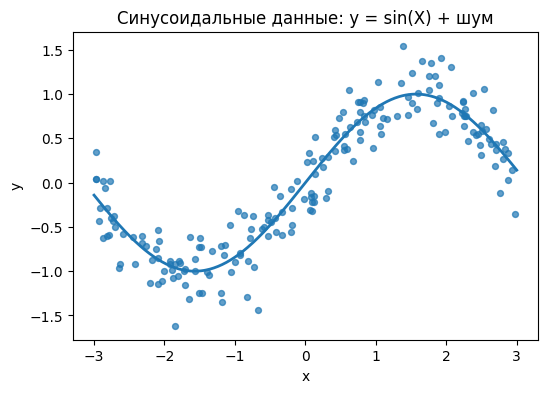

In [2]:
rng = np.random.default_rng(42)

def make_sin_data(n_samples=200, x_range=(-3.0, 3.0), noise_std=0.2, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.uniform(x_range[0], x_range[1], size=(n_samples, 1))
    y = np.sin(X[:, 0]) + rng.normal(0.0, noise_std, size=n_samples)
    return X, y


X, y = make_sin_data(n_samples=200, x_range=(-3.0, 3.0) ,noise_std=0.25, seed=7)

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], y, s=18, alpha=0.7)
xx = np.linspace(-3, 3, 400)
plt.plot(xx, np.sin(xx), lw=2)  # истинная зависимость без шума

plt.title("Синусоидальные данные: y = sin(X) + шум")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Поиск решающего мня путем перебора

In [3]:
class DecisionStumpRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.feature_index_ = None
        self.threshold_ = None
        self.left_value_ = None
        self.right_value_ = None

    def _best_split_1d(self, xj, y):
        order = np.argsort(xj)
        x_sorted, y_sorted = xj[order], y[order]
        uniq = np.unique(x_sorted)
        if uniq.size < 2:
            return None  # нельзя разделить

        thresholds = (uniq[:-1] + uniq[1:]) / 2.0

        best_mse = np.inf
        best_t = None
        best_left_mean = None
        best_right_mean = None

        for t in thresholds:
            left_mask = x_sorted <= t
            right_mask = ~left_mask
            if not left_mask.any() or not right_mask.any():
                continue  # пустой дочерний узел нам не подходит

            y_left = y_sorted[left_mask]
            y_right = y_sorted[right_mask]

            left_mean = y_left.mean()
            right_mean = y_right.mean()

            # Взвешенная MSE двух листьев
            mse = ((np.square(y_left - left_mean).sum() +
                    np.square(y_right - right_mean).sum()) / y.size)

            if mse < best_mse:
                best_mse = mse
                best_t = t
                best_left_mean = left_mean
                best_right_mean = right_mean

        if best_t is None:
            return None
        return best_mse, best_t, best_left_mean, best_right_mean

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y)

        best = None
        for j in range(X.shape[1]):
            res = self._best_split_1d(X[:, j], y)
            if res is None:
                continue
            mse, t, lv, rv = res
            if (best is None) or (mse < best[0]):
                best = (mse, j, t, lv, rv)

        if best is None:
            # нет корректного сплита — возвращаем среднее таргета
            self.feature_index_ = 0
            self.threshold_ = np.inf
            self.left_value_ = y.mean()
            self.right_value_ = y.mean()
        else:
            _, j, t, lv, rv = best
            self.feature_index_ = j
            self.threshold_ = t
            self.left_value_ = lv
            self.right_value_ = rv
        return self

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        j = self.feature_index_
        t = self.threshold_
        y_pred = np.where(X[:, j] <= t, self.left_value_, self.right_value_)
        return y_pred

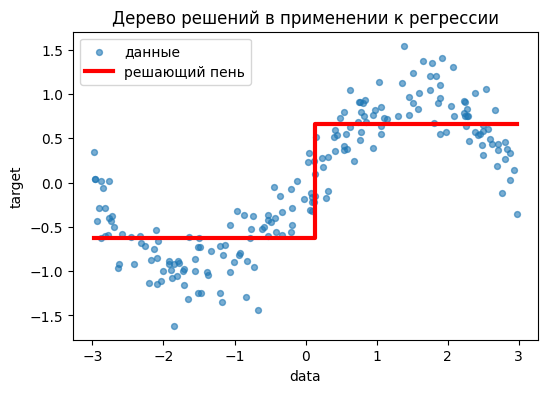

Порог ≈ 0.133 левое среднее ≈ -0.62 правое среднее ≈ 0.666


In [4]:
stump = DecisionStumpRegressor().fit(X, y)

xs_order = np.argsort(X[:,0])
xs = X[xs_order, 0]
pred = stump.predict(X)[xs_order]

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], y, s=18, alpha=0.6, label="данные")
plt.step(xs, pred, where="post", lw=3, color="red", label="решающий пень")
plt.title("Дерево решений в применении к регрессии")
plt.xlabel("data"); plt.ylabel("target")
plt.legend(); plt.show()

print("Порог ≈", round(stump.threshold_, 3),
      "левое среднее ≈", round(stump.left_value_, 3),
      "правое среднее ≈", round(stump.right_value_, 3))


## Жадный алгоритм для деревья, решающего регрессиию на MSE

In [5]:
@dataclass
class _Node:
    is_leaf: bool
    value: float = None
    feature_index: int = None
    threshold: float = None
    left: "._Node" = None
    right: "._Node" = None

class SimpleDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=3, min_samples_split=2, min_improvement=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_improvement = min_improvement
        self.root_ = None

    def _leaf(self, y):
        return _Node(is_leaf=True, value=float(np.mean(y)))

    def _best_split(self, X, y):
        n, p = X.shape
        best = None
        

        global_mean = y.mean()
        base_mse = np.mean((y - global_mean) ** 2)

        for j in range(p):
            # кандидаты-пороги — середины между соседними уникальными значениями
            xj = X[:, j]
            order = np.argsort(xj)
            x_sorted, y_sorted = xj[order], y[order]
            uniq = np.unique(x_sorted)
            if uniq.size < 2:
                continue
            thresholds = (uniq[:-1] + uniq[1:]) / 2.0

            for t in thresholds:
                left_mask = x_sorted <= t
                right_mask = ~left_mask
                if not left_mask.any() or not right_mask.any():
                    continue

                y_left = y_sorted[left_mask]
                y_right = y_sorted[right_mask]
                lv = y_left.mean()
                rv = y_right.mean()
                mse = ((np.square(y_left - lv).sum() +
                        np.square(y_right - rv).sum()) / n)

                if (best is None) or (mse < best[0]):
                    best = (mse, j, t, lv, rv)

        if best is None:
            return None, base_mse
        return best, base_mse

    def _build(self, X, y, depth):
        # Критерии остановки: глубина, мало объектов в листе, нулевая дисперсия
        if depth >= self.max_depth or X.shape[0] < self.min_samples_split or np.allclose(y, y.mean()):
            return self._leaf(y)

        (best, base_mse) = self._best_split(X, y)
        if best is None:
            return self._leaf(y)

        mse, j, t, lv, rv = best
        improvement = base_mse - mse
        if improvement < self.min_improvement:
            return self._leaf(y)

        left_mask = X[:, j] <= t
        right_mask = ~left_mask

        left = self._build(X[left_mask], y[left_mask], depth + 1)
        right = self._build(X[right_mask], y[right_mask], depth + 1)
        return _Node(is_leaf=False, feature_index=j, threshold=t, left=left, right=right)

    def fit(self, X, y):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = np.asarray(y)

        self.root_ = self._build(X, y, depth=0)
        return self

    def _predict_row(self, node, x):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return np.array([self._predict_row(self.root_, x) for x in X])


In [8]:
composition = [SimpleDecisionTreeRegressor(max_depth=10, min_samples_split=5).fit(X, y) for _ in range(10)]

In [ ]:
predictions = []
for tree in composition:
    sub_X_train, sub_y_train = bootstrap(X_train, y_train)
    tree.fit(X_train, y_train)
    prediction = tree.predict(X_val)
    predictions.appen(prediction)
    
final_prediction = sum(prediction) / len(prediction)

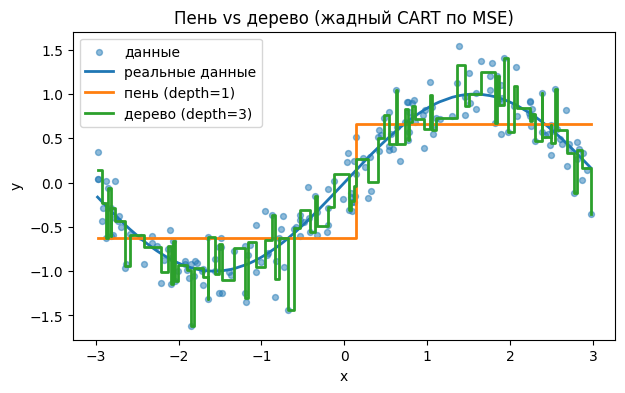

MSE пень: 0.1478
MSE дерево depth=3: 0.0154


In [7]:
tree = SimpleDecisionTreeRegressor(max_depth=10, min_samples_split=5).fit(X, y)
pred_tree = tree.predict(X)

order = np.argsort(X[:, 0])
xs = X[order, 0]
pred_pny = stump.predict(X)[order]
pred_tr = pred_tree[order]

plt.figure(figsize=(7, 4))
plt.scatter(X[:, 0], y, s=18, alpha=0.5, label="данные")
plt.plot(xs, np.sin(xs), lw=2, label="реальные данные")
plt.step(xs, pred_pny, where="post", lw=2, label="пень (depth=1)")
plt.step(xs, pred_tr, where="post", lw=2, label="дерево (depth=3)")
plt.legend()
plt.title("Пень vs дерево (жадный CART по MSE)")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

def mse(y_true, y_pred): 
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(np.mean((y_true - y_pred) ** 2))

print("MSE пень:", round(mse(y, stump.predict(X)), 4))
print("MSE дерево depth=3:", round(mse(y, tree.predict(X)), 4))


## В sklearn

In [ ]:
import argparse
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser(
    description="Decision Tree Regressor."
)
parser.add_argument(
    'filename', type=str, help='Filename with numeric data stored in tuples (x, y).'
)

def find_parameters(X: np.ndarray, y: np.ndarray) -> tuple:
    dec_tree_regression = DecisionTreeRegressor(
				max_depth=1,
				max_leaf_nodes=2,
				criterion='squared_error')

    dec_tree_regression.fit(X, y)

    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_1 = dec_tree_regression.predict(X_test)

    c = dec_tree_regression.tree_.threshold[0]
    a = dec_tree_regression.tree_.value[1][0]
    b = dec_tree_regression.tree_.value[2][0]

    text_representation = tree.export_text(dec_tree_regression, feature_names=['x'])
    print(text_representation)

    plt.figure()
    plt.scatter(X, y, s=20, edgecolor="black", c="blue", label="data")
    plt.plot(X_test, y_1, color="red", linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Дерево решений в применении к регрессии")
    plt.savefig('plot.png')

    return c, a, b

if __name__ == "__main__":
    args = parser.parse_args()
    filename = args.filename

    X = list()
    y = list()

    with open(filename, 'r') as file:
        for line in file:
            line = line.split(',')
            X.append(float(line[0]))
            y.append(float(line[1]))

    X = np.array(X).reshape(-1, 1)
    y = np.array(y).ravel()

    c, a, b = find_parameters(X, y)

    print(f'c = {c}, a = {a[0]}, b = {b[0]}')